In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from thetadata import ThetaClient, OptionReqType, OptionRight, DateRange
import warnings
warnings.filterwarnings("ignore")

In [ ]:
client = ThetaClient()

If you require API support, feel free to join our discord server! http://discord.thetadata.us
------------------------------------------------------------------------------------------------
You are using the free version of Theta Data. You are currently limited to 20 requests / minute.
A data subscription can be purchased at https://thetadata.net. If you already have a ThetaData
subscription, specify the username and passwd parameters.
------------------------------------------------------------------------------------------------
--------------------------------------------------------------

Initiated first time setup, do not terminate the program!

--------------------------------------------------------------


[07-19-2024 01:09:29] INFO: Starting Theta Terminal v1.6.1 Revision C...
[07-19-2024 01:09:29] INFO: Config dir: C:\Users\cwcha\ThetaData\ThetaTerminal
[07-19-2024 01:09:29] INFO: Configuration file not found: created a default config file.
[07-19-2024 01:09:34] INFO: [MDDS] Attempting login as default
[07-19-2024 01:09:34] INFO: [FPSS] Attempting login as default
[07-19-2024 01:09:34] INFO: [MDDS] CONNECTED: [nj-a.thetadata.us:12000], Bundle: STOCK.FREE, OPTION.FREE, INDEX.FREE
[07-19-2024 01:09:34] INFO: [FPSS] CONNECTED: [nj-a.thetadata.us:20000], Bundle: STOCK.FREE, OPTION.FREE, INDEX.FREE
[07-19-2024 01:32:24] WARN: You are using the Python API! Consider using the REST or WebSocket API for better performance and more features: https://http-docs.thetadata.us. These APIs can be used in any language.
[07-19-2024 01:32:43] WARN: You are using the Python API! Consider using the REST or WebSocket API for better performance and more features: https://http-docs.thetadata.us. These APIs ca

In [231]:
ticker = "MCD"
with client.connect():
    exp_dates = client.get_expirations(ticker)
exp_dates_select = exp_dates[630:660]

strikes_list = []
with client.connect():
    for exp_date in exp_dates_select:
        strikes = client.get_strikes(ticker, exp_date)
        strikes_list.append(strikes)

In [232]:
exp_dates_select

630   2024-06-21
631   2024-06-28
632   2024-07-05
633   2024-07-12
634   2024-07-19
635   2024-07-26
636   2024-08-02
637   2024-08-09
638   2024-08-16
639   2024-08-23
640   2024-08-30
641   2024-09-20
642   2024-10-18
643   2024-12-20
644   2025-01-17
645   2025-03-21
646   2025-06-20
647   2026-01-16
dtype: datetime64[ns]

In [234]:
import yfinance as yf
df1 = yf.download(ticker, start='2023-01-01', end=exp_dates_select.iloc[-1], progress=False)
close = df1["Adj Close"]
df1 = pd.DataFrame(strike_list, columns=['strikes'])
df1['diff'] = df1['strikes'] - cl


In [237]:
data_list = []
with client.connect():
    for i in range(1):#len(close)):
        cl = close[i]
        exp_date = exp_dates_select.iloc[8]
        strike_list = [float(j) for j in strikes_list[0]]
        closest_gte_cl_strike = df1[df1['diff'] > 0]['strikes'].iloc[0]
        closest_le_cl_strike = df1[df1['diff'] < 0]['strikes'].iloc[-1]
        
        print(closest_gte_cl_strike, closest_le_cl_strike, exp_date)
        data = client.get_hist_option(
            req = OptionReqType.EOD,
            root= ticker,
            exp= exp_date,
            strike = closest_le_cl_strike,
            right = OptionRight.PUT,
            date_range=DateRange(exp_date - datetime.timedelta(365), exp_date)
        )
        data.columns = ['op', 'cl', 'hi', 'lo', 'vol', 'count', 'da']
        data.set_index('da', inplace=True)
        data['current_cl'] = yf.download(ticker, start=data.index[0], end=data.index[-1]+datetime.timedelta(1), progress=False)['Adj Close']
        data['strike_price'] = closest_le_cl_strike
        data_list.append(data)

285.0 282.5 2024-08-16 00:00:00


TypeError: ThetaClient.get_hist_option() missing 1 required positional argument: 'date_range'

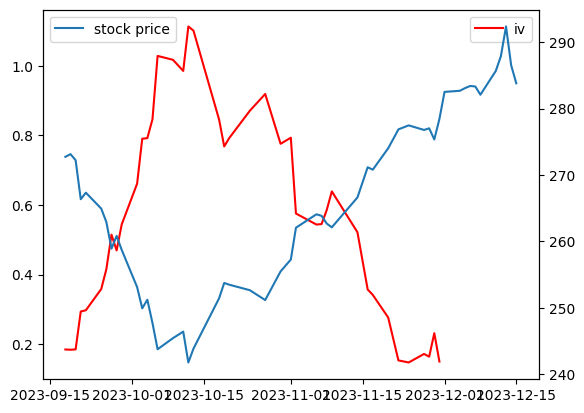

In [229]:
df = data_list[0]
df['current_option_price'] = (df['op'] + df['hi']+ df['lo'] + df['cl'])/4
df['time_to_expiry'] = exp_date - df.index
df['t'] = df['time_to_expiry'].apply(lambda x: x.days/365)
df.head(1)


def calc_implied_vol(row):
    try:
        return implied_volatility(row['current_cl'], row['strike_price'], row['t'], 0.05, row['current_option_price'], option_type='call')
    except Exception as e:
        return None
df['iv'] = df.apply(calc_implied_vol, axis=1)

fig, ax = plt.subplots()
ax.plot(df['iv'], label='iv', color='red')
ax2 = ax.twinx()
ax2.plot(df['current_cl'], label='stock price')
ax.legend()
ax2.legend()

In [185]:
df.head(1)

,op,cl,hi,lo,vol,count,current_cl,strike_price,current_option_price,time_to_expiry,t
da,,,,,,,,,,,
2023-11-15,8.4,8.4,7.9,7.9,4,3,265.534973,277.5,8.15,9 days,0.024658


In [175]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return option_price

def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)


def implied_volatility(S, K, T, r, market_price, option_type='call', tol=1e-8, max_iterations=100):
    sigma = 0.5  # Initial guess
    for i in range(max_iterations):
        option_price = black_scholes(S, K, T, r, sigma, option_type)
        v = vega(S, K, T, r, sigma)
        
        price_diff = option_price - market_price
        
        if abs(price_diff) < tol:
            return sigma
        
        sigma = sigma - price_diff / v
    
    raise ValueError("Implied volatility did not converge")

S = 34.49
K = 35.00
T = 120/365
r = 0.05
market_price = 3.35

implied_vol = implied_volatility(S, K, T, r, market_price, option_type='call')


In [221]:
implied_vol

0.42216145593045773

<Axes: >

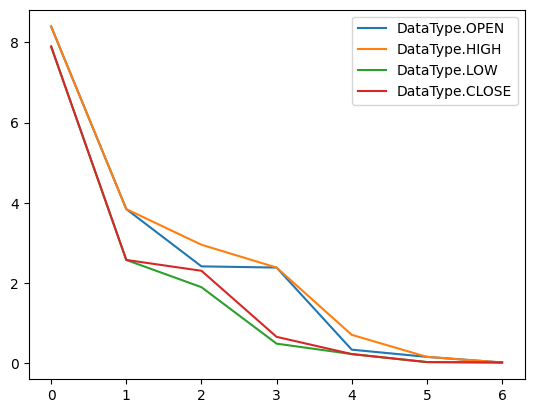

In [118]:
data_list[0].iloc[:, :-3].plot()

In [52]:
datas = []
with client.connect():
    for index, exp_date in enumerate(exp_dates_select):
        data = client.get_hist_option(
            req = OptionReqType.EOD,
            root = ticker,
            exp = exp_date,
            strike = strikes_list[0][int(len(exp_dates_select[0])/2)],
            right = OptionRight.CALL,
            date_range=DateRange(exp_date - datetime.timedelta(90), exp_date)
        )
        datas.append(data)

In [ ]:
curl --request GET \
  --url 'http://127.0.0.1:25510/v2/snapshot/option/quote?root=AAPL&exp=20240809&right=C&strike=280' \
  --header 'Accept: application/json'

In [240]:
def ohlc_snapshot(symbol):
    url = "http://127.0.0.1:25510/v2/bulk_snapshot/option/ohlc"
    querystring = {"root": symbol, "exp": "0", "use_csv": "true"}
    headers = {"Accept": "application/json"}
    return requests.get(url, headers=headers, params=querystring)

In [242]:
import requests
res = ohlc_snapshot(symbol='MCD')


<Response [471]>